# An example of CMIP6 Data Processing

### Import packages

In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore") 

import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

In [2]:
import numpy as np
import xesmf as xe
import xarray as xr

import copy

### Access data

In [3]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
col = open_catalog(url).climate.cmip6_gcs()

In [4]:
# functions for fetching cmip6 data from google cloud
def rename_coords(ds):
    ds = ds.copy()
    """Rename all depth dim to `lev`"""
    if "olevel" in ds.coords:
        ds = ds.rename({"olevel": "lev"})
    if "lev_partial" in ds.coords:
        ds = ds.rename({"lev_partial": "lev"})
    """Rename all latitude, longitude dim to `lat`,`lon`"""
    if 'latitude' in ds.coords:
        ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in ds.coords:
        ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    return ds

def get_dataset(col, var, freq, expe, model, grid):
    dataset = col.search(variable_id = var, table_id = freq, experiment_id = expe, 
                         source_id = model, grid_label = grid).to_dataset_dict(
        zarr_kwargs= {'consolidated': True, 'decode_times':True}, preprocess = rename_coords)
    dataset = dataset[list(dataset)[0]].squeeze('member_id').reset_coords('member_id', drop = True)
    return dataset

The data we are using here is from model GFDL-CM4's piControl data. We are using monthly ocean data and the variables we are looking for is 'so' sanility and 'thetao' temperature.

In [5]:
model_name = 'GFDL-CM4' 
experiment = 'piControl'
frequency = 'Omon'
variables = ['so', 'thetao']

In [6]:
# 'gr' is the regrided data (with one-dimentional lon & lat)
dataset_gr = get_dataset(col, variables, frequency, experiment, model_name, 'gr')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


### Calculate MLD
We want to calculate the mixed layer depth (MLD) from the temperature and sanility we've got.

In [7]:
# functions for calculating potential density of selected year & month from temp & sanility.
def sel_time(ds, start_year, end_year, month = None):
    ds = ds.isel(time = slice((start_year-1)*12, end_year*12))
    if month:
        ds = list(ds.groupby("time.month"))[month-1][-1]
    return ds

def smow(t):
    a = (999.842594, 6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6,
         6.536332e-9)
    T68 = t * 1.00024
    return (a[0] + (a[1] + (a[2] + (a[3] + (a[4] + a[5] * T68) * T68) * T68) *
            T68) * T68)

def dens0(s, t):
    T68 = t * 1.00024
    b = (8.24493e-1, -4.0899e-3, 7.6438e-5, -8.2467e-7, 5.3875e-9)
    c = (-5.72466e-3, 1.0227e-4, -1.6546e-6)
    d = 4.8314e-4
    return (smow(t) + (b[0] + (b[1] + (b[2] + (b[3] + b[4] * T68) * T68) *
            T68) * T68) * s + (c[0] + (c[1] + c[2] * T68) * T68) * s *
            s ** 0.5 + d * s ** 2)

def func_dens0(dataset, start_year, end_year, month_no = 9):
    da_t = sel_time(dataset.thetao, start_year, end_year, month = month_no)
    da_s = sel_time(dataset.so, start_year, end_year, month = month_no)
    da_dens = dens0(da_s, da_t)
    return da_dens

In [8]:
# functions for calculating MLD
def func_mld(dens_diff, depths):
    '''
    Function for calculate mld from density difference (den - den10 - 0.03) and depth
    Return mixed layer depth 
    '''
    if np.isnan(dens_diff[0]):
        mld = np.nan
    elif dens_diff[0] >= 0:
        mld = np.nan
    else:
        nthr_index = np.where(dens_diff > 0)[0]
        if len(nthr_index) == 0:
            naninds = np.where(np.isnan(dens_diff))[0]
            if len(naninds) > 0:
                nanindex = naninds[0]
            else:
                nanindex = len(depths)
            mld = depths[nanindex-1]
        else:
            nind = nthr_index[0] + 1
            mld = np.interp(0, dens_diff[:nind], depths[:nind])
    return mld

def xr_func_mld(dens):
    '''
    Function for parallel computing
    '''
    dens10 = dens.interp(lev = 10, method = 'linear')  # density at 10m
    dens_diff = dens - dens10 - 0.03               # density differences 
    mld = xr.apply_ufunc(
        func_mld, 
        dens_diff.chunk({"time":25, "lat":45, "lon":45}),  
        dens_diff.lev, 
        input_core_dims = [["lev"], ["lev"]], 
        vectorize = True,
        dask = "parallelized",
        output_dtypes = [dens_diff.lev.dtype])
    return mld

In [9]:
start_year = 1
end_year = 500

In [10]:
sep_mld = xr_func_mld(func_dens0(dataset_gr, start_year, end_year))

### Connect to dask

In [11]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    memory = '8G',
    processes = 1,
    cores = 2, 
    nanny = True, 
    silence_logs = 'error')

cluster.scale(16)
client = Client(cluster)
client

Client Scheduler: tcp://192.168.1.2:38499 Dashboard: /proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Plot
Here, we want to plot the average mld over the selected years.

In [12]:
# load the data
sep_mld_avg = sep_mld.mean(dim = 'time')
sep_mld_avg = sep_mld_avg.load()

In [13]:
# import the packages for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point

Text(0.5, 1.0, 'Averaged MLD in Southern Ocean, year 1-500, GFDL-CM4')

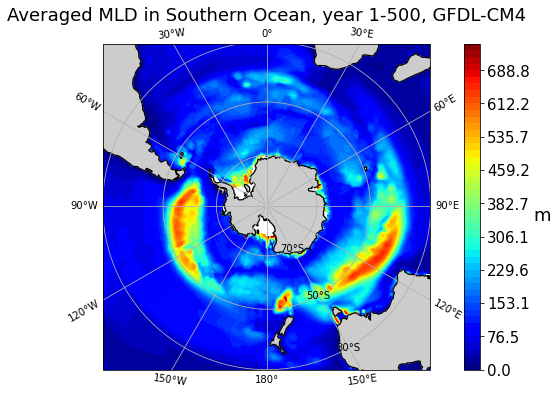

In [14]:
plt_da = sep_mld_avg

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1, color='0.8')
ax.add_feature(cfeature.COASTLINE, linewidth=1.25)

gl = ax.gridlines(
    xlocs = np.arange(-180,180,30), 
    ylocs = np.arange(-90,90,20),
    draw_labels=True, y_inline=True)

plt_mld, plt_lon = add_cyclic_point(plt_da, coord=plt_da.lon)
my_level = np.linspace(0,750,50)
im = ax.contourf(plt_lon, plt_da.lat, plt_mld, transform=ccrs.PlateCarree(), levels = my_level, cmap=plt.cm.jet)
cbar = plt.colorbar(im)
cbar.set_label('m', fontsize=18, rotation=0, horizontalalignment = 'left')
cbar.ax.tick_params(labelsize=15) 

plt.title('Averaged MLD in Southern Ocean, year {}-{}, {}'.format(start_year, end_year, model_name), fontsize=18)

In [15]:
client.close()
cluster.close()